In [1]:
# This database contains sequences of six classes of actions performed by
# 25 subjects in four different conditions d1-d4

# d1 - Static homogenous background
# d2 - -"-                          + Scale variations
# d3 - -"-                          + Different clothes
# d4 - -"-                          + Lighting variations

# Training:   person11, 12, 13, 14, 15, 16, 17, 18
# Validation: person19, 20, 21, 23, 24, 25, 01, 04
# Test:       person22, 02, 03, 05, 06, 07, 08, 09, 10 

In [14]:
%pip install av
%pip install moviepy

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 10.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 38.3 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110744 sha256=f701e220a91144819b884f7b61263d479a5aab364803f0c208b5dbee1ab8f396
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is 

In [20]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import av
import random as rdm
import torchvision.transforms.v2 as transforms
from tqdm import tqdm

import os
import torch
import torch.nn.functional as F

from torch.utils.data import Dataset
from torchvision.io import read_video
from torch.utils.data import DataLoader
import torchvision
import multiprocessing
import time
from torch.nn.utils.rnn import pad_sequence

num_cores = multiprocessing.cpu_count()

print("This machine has {} CPU cores.".format(num_cores))

def set_seed(seed=42):
    rdm.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

set_seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

This machine has 2 CPU cores.
cuda:0


In [22]:
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
from utils import *

--2023-05-29 12:04:50--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2023-05-29 12:04:51--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   2.57K  --.-KB/s    in 0s      

2023-05-29 12:04:51 (40.2 MB/s) - ‘utils.py.1’ saved [2627/2627]



FPS:  25.0


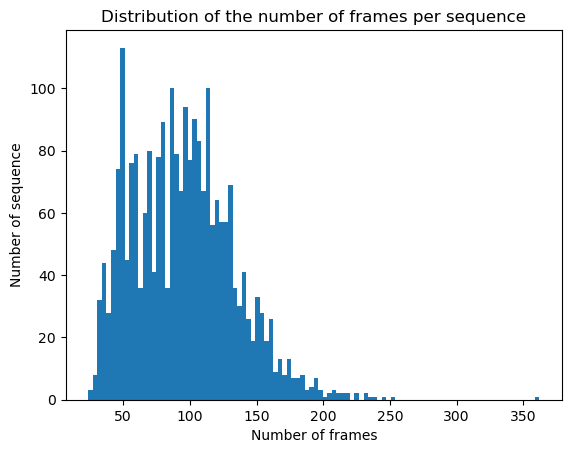

The shortest sequence is in video person10_handclapping_d1 from frame 261 to 284 with a length of 24 frames.


In [24]:
# histogram with the distribution of the number of frames per video
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip

clip = VideoFileClip("/kaggle/input/kth-raw/KTH/boxing/person01_boxing_d1_uncomp.avi")
print("FPS: ", clip.fps)

shortest_sequence = None
shortest_length = float('inf')
txt_path = '/kaggle/input/kth-raw/KTH/sequences.txt'
with open(txt_path, 'r') as f:
    lines = f.readlines()
    lengths = []
    for line in lines:
        video_id, *frame_sequences = line.strip().split(',')
        for frame_sequence in frame_sequences:
            start, end = map(int, frame_sequence.split('-'))
            length = end - start + 1
            lengths.append(length)
            if length < shortest_length:
                shortest_sequence = (video_id, start, end)
                shortest_length = length
            
plt.hist(lengths, bins=100)
plt.xlabel('Number of frames')
plt.ylabel('Number of sequence')
plt.title('Distribution of the number of frames per sequence')
plt.show()

print(f"The shortest sequence is in video {shortest_sequence[0]} from frame {shortest_sequence[1]} to {shortest_sequence[2]} with a length of {shortest_length} frames.")

In [25]:
# how many segments have more than N frames?
num_frames = 50
sum_frames = sum([length > num_frames for length in lengths])
print(f"{sum_frames} videos have more than {num_frames} frames.\n\n That is {sum_frames/len(lengths)*100:.2f}% of the videos.")

2086 videos have more than 50 frames.

 That is 87.24% of the videos.


In [30]:
# training are persons :11, 12, 13, 14, 15, 16, 17, 18
# validation are persons : 19, 20, 21, 23, 24, 25, 01, 04
# test are persons : 22, 02, 03, 05, 06, 07, 08, 09, 10
# https://pytorch.org/vision/main/auto_examples/plot_optical_flow.html#sphx-glr-auto-examples-plot-optical-flow-py
def frame_to_sec(frame):
    frames_per_second = 25
    return frame/frames_per_second

class KTHDataset(Dataset):
    def __init__(self, root, txt_path, transforms=None, subset='train', num_frames=16):
        self.root = root
        self.transforms = transforms
        self.subset = subset
        self.data = []
        self.num_frames = num_frames
        self.label_to_int = {"boxing": 0, "handclapping": 1, "handwaving": 2,
                             "jogging": 3, "running": 4, "walking": 5}
        self.int_to_label = {v: k for k, v in self.label_to_int.items()}

        with open(txt_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                video_id, *frame_sequences = line.strip().split(',')
                person_id, action, _ = video_id.split('_')

                person_number = int(person_id.replace("person", ""))
                
                if self._is_in_subset(person_number):
                    for frame_sequence in frame_sequences:
                        start, end = frame_sequence.split('-')
                        if int(end) - int(start) + 1 >= self.num_frames:
                            self.data.append((video_id, frame_to_sec(int(start)), frame_to_sec(int(start) + self.num_frames - 1), self.label_to_int[action])) # truncates the sequence to num_frames

    def get_action(self, label):
        return self.int_to_label[label]
    
    def _is_in_subset(self, person_number):
        # check if the person number is in the subset
        if self.subset == 'train':
            return person_number in [11, 12, 13, 14, 15, 16, 17, 18, 22, 2, 3, 5, 6]
        elif self.subset == 'validation':
            return person_number in [19, 20, 21, 23, 24, 25, 1, 4, 7, 8, 9, 10]
        elif self.subset == 'test':
            return person_number in [] # i don't need to test so dispatched all persons on train and valid
        else:
            return False
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_id, start_frame, end_frame, action = self.data[idx]
        video_path = os.path.join(self.root+'/'+self.get_action(action)+'/', video_id+'_uncomp' + '.avi')
        print(start_frame, end_frame)
        video, audio, info = read_video(video_path, start_frame, end_frame, output_format="TCHW", pts_unit='sec')

        if self.transforms:
            video = self.transforms(video)
        
        # permute from TCHW to CTHW
        video = torch.permute(video, (1, 0, 2, 3)) # (C, T, H, W)
        
        # make sure that all videos have the same number of frames
        if video.shape[1] < self.num_frames:
            # pad the video with the last frame
            video = F.pad(video, (0, 0, 0, 0, 0, self.num_frames - video.shape[1]), mode='replicate')
        elif video.shape[1] > self.num_frames:
            # truncate the video
            video = video[:, :self.num_frames, :, :]
            
        return video, action

In [31]:
def get_loaders(data_path, sequences_path, resized, batch_size=4, cuda=True, num_workers=2, num_frames=22):
    transform_outer = transforms.Compose([
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomHorizontalFlip(),
    ])

    transform_inner = transforms.Compose([
        #transforms.Resize(resized, antialias=True),
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.5], [0.5])
    ])

    transform_train = transforms.Compose([
        transform_outer,
        transform_inner
    ])

    transform_test = transforms.Compose([
        transform_inner
    ])
    
    train_dataset = KTHDataset(data_path, sequences_path, transforms=transform_train, subset='train', num_frames=num_frames)
    val_dataset = KTHDataset(data_path, sequences_path, transforms=transform_test, subset='validation', num_frames=num_frames)
    test_dataset = KTHDataset(data_path, sequences_path, transforms=transform_test, subset='test', num_frames=num_frames)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=cuda)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=cuda)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=cuda)

    return train_loader, val_loader, test_loader

In [32]:
# Test the dataloader
data_path = '/kaggle/input/kth-raw/KTH'
sequences_path = '/kaggle/input/kth-raw/KTH/sequences.txt'

train_set, valid_set, _ = get_loaders(data_path, sequences_path, (64, 64), 10, False, 2, 50)
for i, (videos, labels) in enumerate(train_set):
    print('shape of batch :', videos.shape) # should get [batch_size, 3, seq_len, resized[0], resized[1]]
    print(labels.shape) # should get [batch_size], the labels of the videos in the batch
    if i == 5:
        break
        
for i, (videos, labels) in enumerate(valid_set):
    print('shape of batch :', videos.shape) # should get [batch_size, 3, seq_len, resized[0], resized[1]]
    print(labels.shape) # should get [batch_size], the labels of the videos in the batch
    if i == 5:
        break

10.427.6  12.3629.56

7.08.72  8.9610.68

3.64 5.60.04
 2.0
5.48 7.44
5.12 7.08
11.0 12.96
8.44 10.4
15.8 17.76
12.36 14.32
8.24 10.2
10.6 12.56
15.32 17.28
0.04 2.0
9.88 11.84
5.36 7.32


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b89adac9ea0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b89adac9ea0>    
if w.is_alive():Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'    self._shutdown_workers()
AssertionError: 
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
can only test a child process    if w.is_alive():

  File "/op

11.88 13.84
11.04 13.0
4.12 6.0810.08
 12.04


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 264, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 50, 120, 160] at entry 0 and [3, 51, 120, 160] at entry 1


6.0 7.96
4.32 6.28
17.0 18.96
13.52 15.48
0.04 2.0
8.2 10.16
5.4 7.36
0.04 2.0
9.08 11.04
25.6 27.56
14.8 16.76
0.04 2.0
9.44 11.4
4.6 6.56
26.0 27.966.8 
8.76
9.28 11.24
9.2 11.16
3.32 5.28
16.88 18.84
4.44 6.4
5.12 7.08
9.8 11.76
14.12 16.08
0.04 2.0
9.4 11.36
7.4 9.36
12.2 14.16


In [ ]:
import torch.nn as nn
    
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=6, in_channels=3, dropout_prob=0.5):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(32)
        self.relu = nn.ReLU(inplace=True) # ReLU activation
        self.maxpool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        self.maxpool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(128)
        self.maxpool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(38400, num_classes)
        
    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        # print(x.shape)
        #x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x

In [ ]:
class Metric: 
    def __init__(self):
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
    
def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):
        
        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        #if i % PRINT_INTERVAL == 0:
        #    print('[{0:s} Batch {1:03d}/{2:03d}]\t'
        #          'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
        #          'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #          'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
        #          'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
        #           "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
        #           top1=avg_top1_acc, top5=avg_top5_acc))
            #if optimizer:
                #loss_plot.plot()

    # Print summary
    #print('\n===============> Total time {batch_time:d}s\t'
    #      'Avg loss {loss.avg:.4f}\t'
    #      'Avg Prec@1 {top1.avg:5.2f} %\t'
    #      'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
    #       batch_time=int(avg_batch_time.sum), loss=avg_loss,
    #       top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

In [ ]:
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

def main(data_path, sequences_path, resized, num_frames, batch_size=128, lr=0.1, epochs=5, cuda=False, num_workers=2, dropout_prob=0.1):

    # define model, loss, optim
    model = Simple3DCNN(dropout_prob=dropout_prob)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test, _ = get_loaders(data_path, sequences_path, resized, batch_size, cuda, num_workers, num_frames)

    # init plots
    listm = []
    #plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()
    #accs_train= []
    #accs_test= []

    # We iterate on the epochs
    for i in tqdm(range(epochs)):
        m = Metric()

        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Update learning rate
        scheduler.step()

        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        #plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
        m.acc_train = top1_acc.avg
        m.acc_test = top1_acc_test.avg
        m.loss_train = loss.avg
        m.loss_test = loss_test.avg
        listm.append(m)
        print( f"********** EPOCH {i+1} acc train={m.acc_train:.2f}%, acc test={m.acc_test:.2f}%, loss train={m.loss_train:.3f}, loss test={m.loss_test:.3f} **********")
        #accs_train.append(top1_acc_ = test)
        #accs_test.append(top1_acc_test)

    return listm

In [29]:
data_path = '/kaggle/input/kth-raw/KTH'
sequences_path = '/kaggle/input/kth-raw/KTH/sequences.txt'

resized = (64, 64)
batch_size = 4

lr = 0.0001
epochs = 40
cuda = torch.cuda.is_available()
num_workers = 2
dropout_prob = 0.1

num_frames = 50

main(data_path, sequences_path, resized, batch_size, num_frames, lr, epochs, cuda, num_workers, dropout_prob)

  0%|          | 0/40 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b89adac9ea0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b89adac9ea0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_wo

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 264, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 4, 120, 160] at entry 0 and [3, 5, 120, 160] at entry 14


<Figure size 640x480 with 0 Axes>